# Shakemaps

<div style="text-align:center;">
    <img src="Image\Untitled.jpeg" alt="Deskripsi Gambar">
</div>

Shakemaps (Peta guncangan) merupakan peta yang berisikan tentang besarnya dampak yang diberikan oleh gempa di suatu daerah. Data yang digunakan dalam pembuatan shakemaps berupa:

1. Waveform dari stasiun
2. Metadata stasiun

Alur pembuatan shakemaps seperti dibawah:

In [1]:
# Import Module
from pathlib import Path
import pandas as pd
import numpy as np
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.util.attribdict import AttribDict

# Alrogitma menghitung PGA

In [2]:
infile = "Kejadian.csv" #data gempa yang digunakan
kejadian = pd.read_csv(infile,parse_dates=True)
outfile_name = "station.csv" #jarak gempa ke stasiun

In [3]:
st = read('Data/Waveform/*')
# print(st.__str__(extended=True)) #menampilkan semua data

inv = read_inventory("Data/stasiun/*", format='STATIONXML')

data_list = []  # Inisialisasi list untuk menyimpan data dari setiap iterasi

for index, row in kejadian.iterrows():
    pga = []  # Inisialisasi list pga di setiap iterasi
    distances = []  # Menggunakan nama variabel yang berbeda untuk list jarak
    for tr in st:
        net = tr.stats.network
        sta = tr.stats.station
        cha = tr.stats.channel
        n = tr.stats.npts
        if cha == "SHE":
            if n > 25000:
                # tr.write(f'{net}.{sta}.00.{cha}.mseed',format='mseed')
                tr.detrend(type="linear")  # equivalent to rtr in SAC
                tr.remove_response(inventory=inv, output="ACC", zero_mean=True)  # correct to displacement
                tr.detrend(type="linear")
                tr.detrend(type="demean")  # remove mean
                pga_value = np.max(np.abs(tr))
                # print(pga_value)
                meta = inv.get_channel_metadata(tr.id)
                stla = meta['latitude']
                stlo = meta['longitude']
                stel = meta['elevation']
                dist, az, baz = gps2dist_azimuth(row.lat, row.lon, meta['latitude'], meta['longitude'])
                distkm = dist / 1000
                distances.append(distkm)  # Menambahkan nilai jarak ke dalam list distances
                # print(int(pga_value))
                pga.append(pga_value)  # Menambahkan nilai pga ke dalam list pga

                data_list.append({'network': net, 'station': sta, 'channel': cha,'lon': stlo ,'lat': stla, 'distance': distkm, 'pga': pga_value})

# Setelah semua iterasi selesai, buat dataframe dari list data_list
df = pd.DataFrame(data_list)
df = df.sort_values("distance")
df.to_csv("%s"%(outfile_name),index=False)

# Sekarang Anda memiliki dataframe df yang berisi data dari semua iterasi
# Anda dapat melakukan apa yang Anda inginkan dengan dataframe ini, seperti menyimpannya dalam file atau melakukan analisis lebih lanjut

In [4]:
import matplotlib.pyplot as plt

data = pd.read_csv("station.csv")
print(data.columns)
print('=======================================================')
print(kejadian.columns)

Index(['network', 'station', 'channel', 'lon', 'lat', 'distance', 'pga'], dtype='object')
Index(['evid', 'origin', 'jdate', 'lon', 'lat', 'depth', 'mw', 'auth'], dtype='object')


In [5]:
import numpy as np
from scipy.interpolate import griddata # Min max coordinates
xmin,xmax = min(x),max(x)
ymin,ymax = min(y),max(y)
xgrid = np.linspace(xmin, xmax, 1000)
ygrid = np.linspace(ymin, ymax, 1000)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)# Interpolation
cba = griddata((x,y),col,(xgrid,ygrid), method = 'cubic')

NameError: name 'x' is not defined

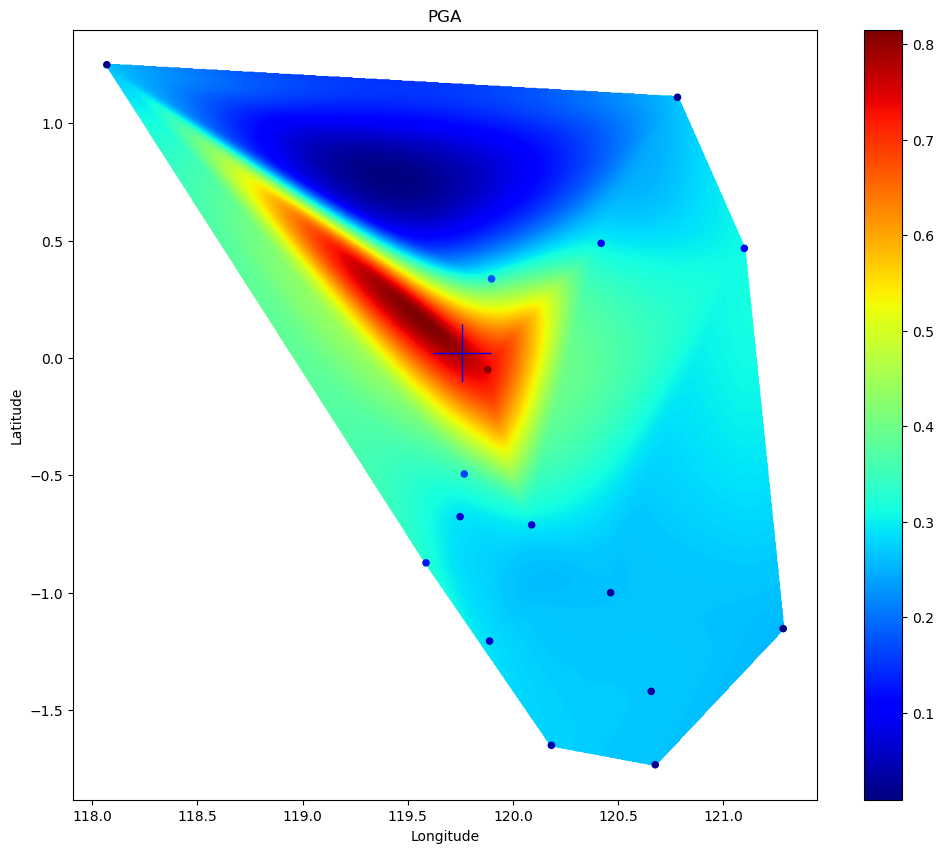

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 10))
plt.scatter(xgrid, ygrid, c = cba, cmap = 'jet', s=1)
plt.scatter(x, y, c = col, cmap = 'jet', s=20)
plt.plot(kejadian.lon, kejadian.lat,'b+',markersize=42)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('PGA')
plt.show()

In [7]:
import pygmt

In [9]:
region = [
    kejadian.lon.min() - 2,
    kejadian.lon.max() + 2,
    kejadian.lat.min() - 2,
    kejadian.lat.max() + 2,
]

proj= 'M12c'
fig = pygmt.Figure()
fig.basemap(region=region, projection=proj, frame=True)
fig.coast(land="gray", water='white')
fig.plot(x=kejadian.lon,y=kejadian.lat,style='a0.5c',fill='red')
pygmt.makecpt(cmap="viridis", series=[data.pga.min(), data.pga.max()],output='pga.cpt')
fig.plot(
    x=data.lon,
    y=data.lat,
    fill=data.pga,
    cmap='pga.cpt',
    style="c0.75c",
    pen="black",
    transparency='20'
)
fig.colorbar(frame="af+lPGA (m/s^2)")
fig.show()